In [2]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [2]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)
    
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [3]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

import os

def get_files_list(path):
    print(path)
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            files.append(os.path.join(r, file))
    return files

D:/Development/TSAI/EVA/PaintingsDS/test/content/
D:/Development/TSAI/EVA/PaintingsDS/test/style/
5
5


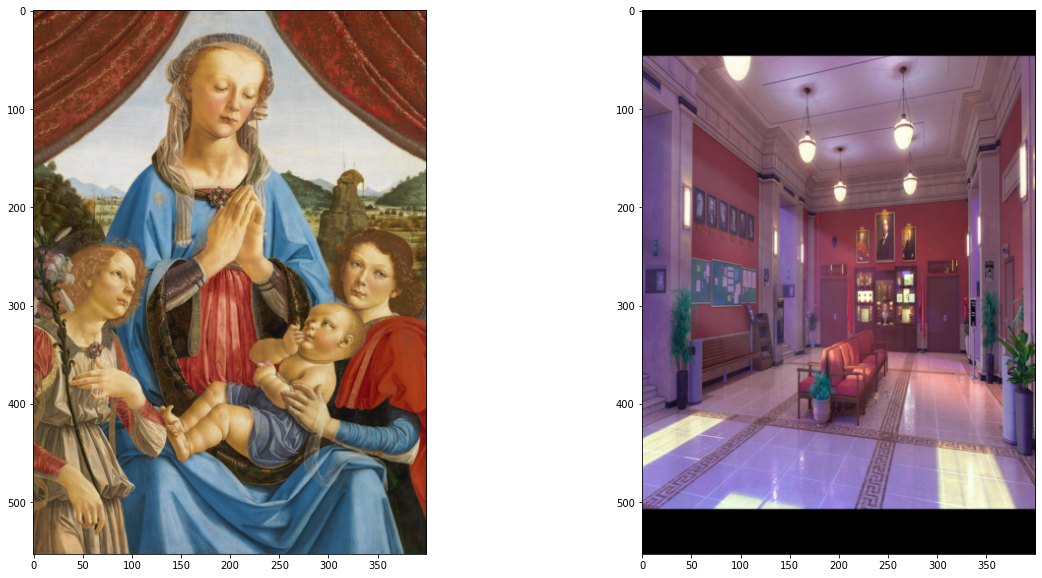

In [4]:
content_files = get_files_list("D:/Development/TSAI/EVA/PaintingsDS/test/content/")
style_files = get_files_list("D:/Development/TSAI/EVA/PaintingsDS/test/style/")

print(len(content_files))
print(len(style_files))

# load in content and style image
content = load_image(content_files[0]).to(device)
# Resize style to match content, makes code easier
style = load_image(style_files[0], shape=content.shape[-2:]).to(device)

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [5]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
# style_weight = 1e10  # beta
# style_weight = 1e6  # beta
style_weight = 1e7  # beta

D:/Development/TSAI/EVA/PaintingsDS/test/content/1.jpg


D:/Development/TSAI/EVA/PaintingsDS/test/style/1.jpg


Total loss:  2947238.5


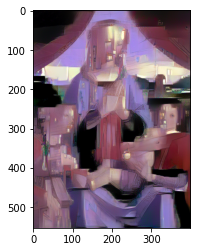

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/2.jpg


Total loss:  1157625.875


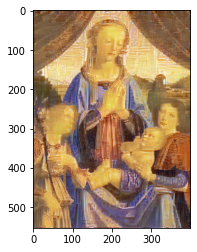

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/3.jpg


Total loss:  2513633.25


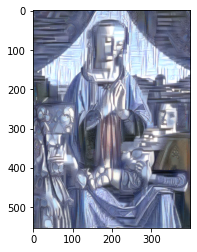

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/4.jpg


Total loss:  3615715.25


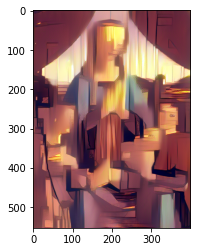

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/5.png


Total loss:  2443985.5


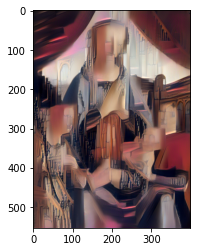

Saved checkpoint


D:/Development/TSAI/EVA/PaintingsDS/test/content/2.jpg


D:/Development/TSAI/EVA/PaintingsDS/test/style/1.jpg


Total loss:  22825904.0


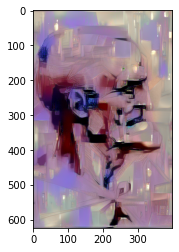

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/2.jpg


Total loss:  2912483.0


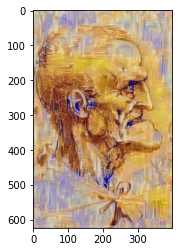

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/3.jpg


Total loss:  5197866.0


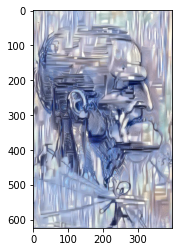

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/4.jpg


Total loss:  23044388.0


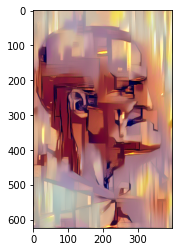

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/5.png


Total loss:  25892432.0


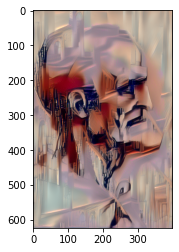

Saved checkpoint


D:/Development/TSAI/EVA/PaintingsDS/test/content/3.jpg


D:/Development/TSAI/EVA/PaintingsDS/test/style/1.jpg


Total loss:  2144973.25


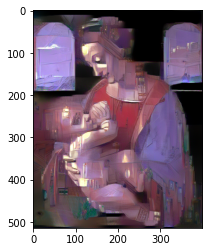

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/2.jpg


Total loss:  3892380.75


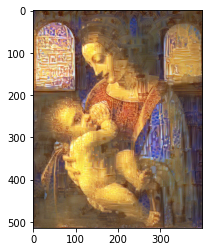

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/3.jpg


Total loss:  5600050.5


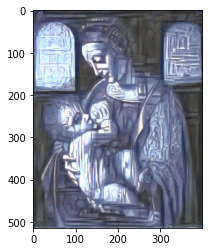

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/4.jpg


Total loss:  5599852.5


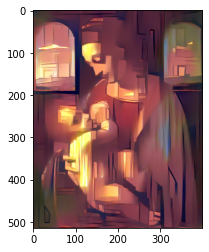

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/5.png


Total loss:  2776708.0


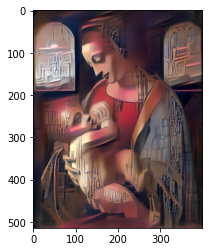

Saved checkpoint


D:/Development/TSAI/EVA/PaintingsDS/test/content/4.jpg


D:/Development/TSAI/EVA/PaintingsDS/test/style/1.jpg


Total loss:  6428956.0


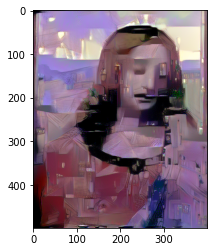

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/2.jpg


Total loss:  1127327.375


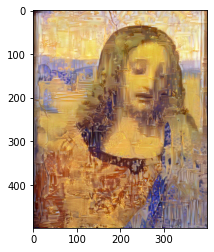

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/3.jpg


Total loss:  2872675.75


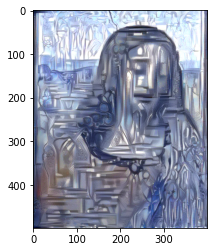

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/4.jpg


Total loss:  5711169.5


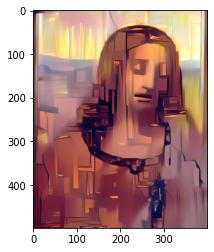

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/5.png


Total loss:  6025222.5


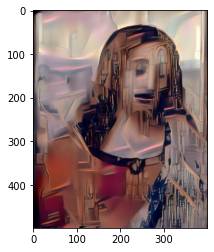

Saved checkpoint


D:/Development/TSAI/EVA/PaintingsDS/test/content/5.jpg


D:/Development/TSAI/EVA/PaintingsDS/test/style/1.jpg


Total loss:  2126336.75


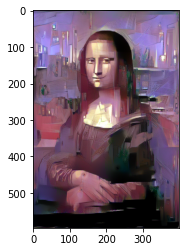

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/2.jpg


Total loss:  3489693.75


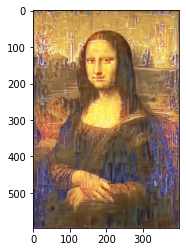

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/3.jpg


Total loss:  5182307.5


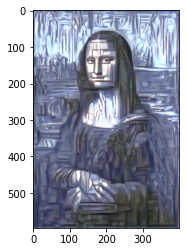

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/4.jpg


Total loss:  5096889.0


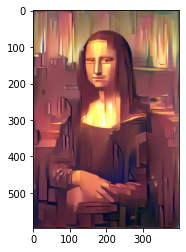

Saved checkpoint

D:/Development/TSAI/EVA/PaintingsDS/test/style/5.png


Total loss:  2741446.0


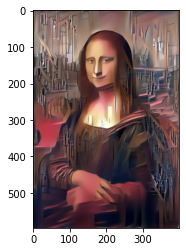

Saved checkpoint





In [6]:
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
for content_f in tqdm(content_files):
    print(content_f)
    content = load_image(content_f).to(device)    
    
    for style_f in tqdm(style_files):
        print(style_f)
        # Resize style to match content, makes code easier
        style = load_image(style_f, shape=content.shape[-2:]).to(device)

        # get content and style features only once before training
        content_features = get_features(content, vgg)
        style_features = get_features(style, vgg)

        # calculate the gram matrices for each layer of our style representation
        style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

        # create a third "target" image and prep it for change
        # it is a good idea to start of with the target as a copy of our *content* image
        # then iteratively change its style
        target = content.clone().requires_grad_(True).to(device)
        # for displaying the target image, intermittently

        # iteration hyperparameters
        optimizer = optim.Adam([target], lr=0.003)
        steps = 5000  # decide how many iterations to update your image (5000)
        show_every = steps -1 

        for ii in tqdm(range(1, steps+1)):

            # get the features from your target image
            target_features = get_features(target, vgg)

            # the content loss
            content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

            # the style loss
            # initialize the style loss to 0
            style_loss = 0
            # then add to it for each layer's gram matrix loss
            for layer in style_weights:
                # get the "target" style representation for the layer
                target_feature = target_features[layer]
                target_gram = gram_matrix(target_feature)
                _, d, h, w = target_feature.shape
                # get the "style" style representation
                style_gram = style_grams[layer]
                # the style loss for one layer, weighted appropriately
                layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
                # add to the style loss
                style_loss += layer_style_loss / (d * h * w)

            # calculate the *total* loss
            total_loss = content_weight * content_loss + style_weight * style_loss

            # update your target image
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # display intermediate images and print the loss
            if  ii % show_every == 0:
                print('Total loss: ', total_loss.item())
                plt.imshow(im_convert(target))
                plt.show()               
                
            if  ii % show_every == 0:
                checkpoint_path = "checkpoint.pth"
                torch.save(vgg.state_dict(), checkpoint_path)
                print('Saved checkpoint')

In [3]:
vgg = models.vgg19(pretrained=False).features
vgg.load_state_dict(torch.load("checkpoint.pth"))
vgg.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
!pip install onnx onnxruntime
from onnxruntime.quantization import quantize
from onnxruntime.quantization import QuantizationMode
import io
import numpy as np
import torch.onnx
import copy

In [30]:
# Input to the model
torch_model = vgg
torch_model = torch_model.to('cpu')
print(next(torch_model.parameters()).is_cuda)
batch_size = 1
x = torch.randn(64, 3, 256, 256)
x = x.to('cpu')
torch_out = torch_model(x)

False


In [31]:
# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "style.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  # verbose = True,
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=False,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [35]:
from onnxruntime.quantization import quantize
from onnxruntime.quantization import QuantizationMode
import onnx

In [36]:
onnx_model = onnx.load("style.onnx")
quantized_model = quantize(onnx_model, quantization_mode=QuantizationMode.IntegerOps, static=False)
onnx.save(quantized_model, 'style.quantized.onnx')

         Please use quantize_static for static quantization, quantize_dynamic for dynamic quantization.


In [ ]:
# import onnx.utils
# polished_model = onnx.utils.polish_model(onnx_model)